# Modeling a Ball Channel Pendulum

Below is a video of a simple cardboard pendulum that has a metal ball in a semi-circular channel mounted above the pendulum's rotational joint. It is an interesting dynamic system that can be constructed and experimented with. This system seems to behave like a single degree of freedom system, i.e. that the ball's location is a kinematic function of the pendulum's angle. But this may not actually be the case. It depends on the nature of the motion of the ball with respect to the channel. If the ball rolls without slipping in the channel it is a single degree of freedom system. If the ball can slip and roll it is at a minimum a two degree of freedom system. In this notebook we will derive the equations of motion of the system considering the ball slips and doesn't roll in the channel.

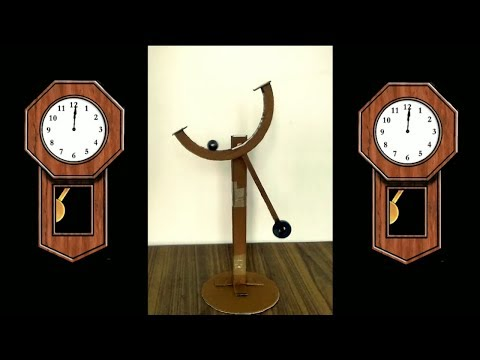

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('3pJdkssUdfU', width=600, height=480)

# Imports and setup

In [2]:
import sympy as sm
import numpy as np

In [3]:
sm.init_printing()

In [4]:
%matplotlib widget

# Free Body Diagram

Assumptions:

- Pendulum pivot is frictionless
- Pendulum is a simple pendulum
- Ball is a point mass that slides without friction in the pendulum channel

![](ball-channel-pendulum-fbd.png)

# Constants

Create a symbol for each of the system's contant parameters.

- $m_p$: mass of the pendulum
- $m_b$: mass of the ball
- $l$: length of the pendulum
- $r$: radius of the channel
- $g$: acceleration due to gravity

In [5]:
mp, mb, r, l, g = sm.symbols('m_p, m_b, r, l, g', real=True, positive=True)

# Generalized Coordinates

Create functions of time for each generalized coordinate.

- $\theta(t)$: angle of the pendulum
- $\phi(t)$: angle of the line from the center of the channel semi-circle to the ball

In [6]:
t = sm.symbols('t')

In [7]:
theta = sm.Function('theta')(t)
phi = sm.Function('phi')(t)

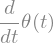

In [8]:
theta.diff()

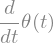

In [9]:
theta.diff(t)

Introduce two new variables for the generalized speeds:

$$
\alpha = \dot{\theta} \\
\beta = \dot{\phi}
$$

In [10]:
alpha = sm.Function('alpha')(t)
beta = sm.Function('beta')(t)

# Kinetic Energy

Write the kinetic energy in terms of the generalized coordinates.

Pendulum:

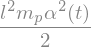

In [11]:
Tp = mp * (l * alpha)**2 / 2
Tp

Ball

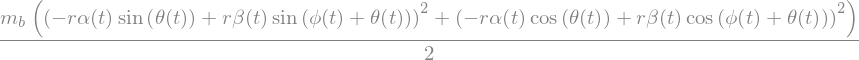

In [12]:
Tb = mb / 2 * ((-r * alpha * sm.cos(theta) + beta * r * sm.cos(theta + phi))**2 +
               (-r * alpha * sm.sin(theta) + beta * r * sm.sin(theta + phi))**2)
Tb

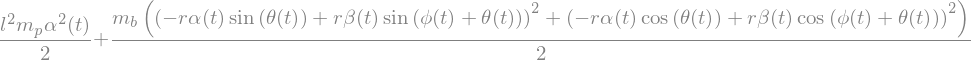

In [13]:
T = Tp + Tb
T

# Potential Energy

Each particle (pendulum bob and the ball) has a potential energy associated with how high the mass rises.

In [14]:
U = mp * g * (l - l * sm.cos(theta)) + mb * g * (r * sm.cos(theta) - r * sm.cos(theta + phi))
U

# Lagrange's equation of the second kind

There are two generalized coordinates with two degrees of freedom and thus two equations of motion.

$$
0 = f_\theta(\theta, \phi, \alpha, \beta, \dot{\alpha}, \dot{\beta}, t) \\
0 = f_\phi(\theta, \phi, \alpha, \beta, \dot{\alpha}, \dot{\beta}, t) \\
$$

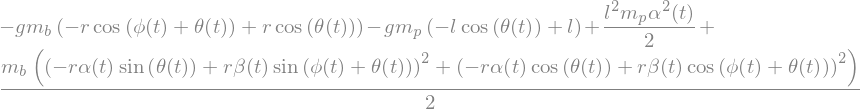

In [15]:
L = T - U
L

In [16]:
gs_repl = {theta.diff(): alpha, phi.diff(): beta}

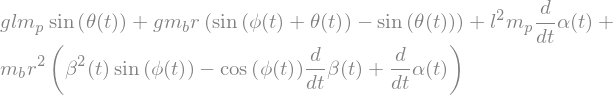

In [17]:
f_theta = L.diff(alpha).diff(t).subs(gs_repl) - L.diff(theta)
f_theta = sm.trigsimp(f_theta)
f_theta

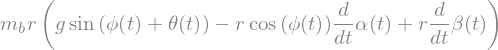

In [18]:
f_phi = L.diff(beta).diff(t).subs(gs_repl) - L.diff(phi)
f_phi = sm.trigsimp(f_phi)
f_phi

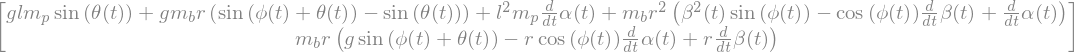

In [19]:
f = sm.Matrix([f_theta, f_phi])
f

The equations are motion are based on Newton's second law and Euler's equations, thus it is guaranteed that terms in $\mathbf{f}$ that include $\dot{\mathbf{u}}$ are linear with respect to $\dot{\mathbf{u}}$. So the equations of motion can be written in this matrix form:

$$
\mathbf{f}(\mathbf{c}, \mathbf{s}, \dot{\mathbf{s}}, t) = \mathbf{I}(\mathbf{c}, t)\dot{\mathbf{s}} + \mathbf{g}(\mathbf{c}, \mathbf{s}, t) = 0
$$

$\mathbf{I}$ is called the "mass matrix" of the nonlinear equations. If the derivatives of $\mathbf{f}$ with respect to $\dot{\mathbf{u}}$ are computed, i.e. the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of $\mathbf{f}$ with respect to $\dot{\mathbf{u}}$, then you can obtain the mass matrix.

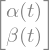

In [20]:
sbar = sm.Matrix([alpha, beta])
sbar

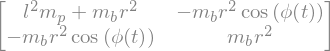

In [21]:
Imat = f.jacobian(sbar.diff())
Imat

$$\mathbf{g} = \mathbf{f}|_{\dot{\mathbf{s}}=\mathbf{0}}$$

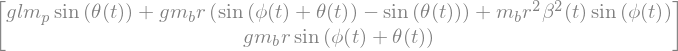

In [22]:
gbar = f.subs({alpha.diff(t): 0, beta.diff(t): 0})
gbar

The explicit first order form has all of the $\dot{\mathbf{s}}$ on the left hand side. This requires solving the linear system of equations:

$$\mathbf{I}\dot{\mathbf{s}}=-\mathbf{g}$$

The mathematical solution is:

$$\dot{\mathbf{s}}=-\mathbf{I}^{-1}\mathbf{g}$$

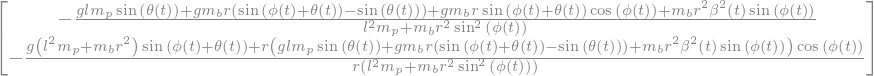

In [23]:
sdotbar = -Imat.inv() * gbar
sdotbar.simplify()
sdotbar

A better way to solve the system of linear equations is to use Guassian elmination. SymPy has a variety of methods for sovling linear systems. The LU decomposition method of Guassian elimination is a generally good choice for this and for large number of degrees of freedom this will provide reasonable computation time. For very large $n$ this should be done numerically instead of symbolically.

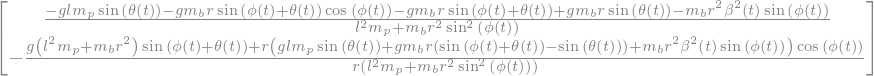

In [24]:
sdotbar = -Imat.LUsolve(gbar)
sdotbar.simplify()
sdotbar

Note the differences in timing below. For systems with a large number of degrees of freedom, this gap in timing will increase significantly.

In [25]:
%%timeit
-Imat.inv() * gbar

874 ms ± 68.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit
-Imat.LUsolve(gbar)

883 µs ± 148 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Simulation of the nonlinear system

Resonance has a prepared system that is only missing the equations of motion.

In [27]:
from resonance.nonlinear_systems import BallChannelPendulumSystem

In [28]:
sys = BallChannelPendulumSystem()

In [29]:
sys.constants

{'mp': 0.012, 'mb': 0.0035, 'r': 0.1, 'l': 0.2, 'g': 9.81}

In [30]:
sys.coordinates

_CoordinatesDict([('theta', 0.17453292519943295), ('phi', -0.17453292519943295)])

In [31]:
sys.speeds

_CoordinatesDict([('alpha', 0.0), ('beta', 0.0)])

The full first order ordinary differential equations are:

$$
\dot{\theta} = \alpha \\
\dot{\phi} = \beta \\
\dot{\alpha} = f_{\alpha}(\theta, \phi, \alpha, \beta, t) \\
\dot{\beta} = f_{\beta}(\theta, \phi, \alpha, \beta, t)
$$

where:

$$
\dot{\mathbf{c}}=\begin{bmatrix}
\theta \\
\phi
\end{bmatrix} \\
\dot{\mathbf{s}}=-\mathbf{I}^{-1}\mathbf{g} =
\begin{bmatrix}
f_{\alpha}(\theta, \phi, \alpha, \beta, t) \\
f_{\beta}(\theta, \phi, \alpha, \beta, t)
\end{bmatrix}
$$

Introducing:

$$\mathbf{x} = 
\begin{bmatrix}
\mathbf{c} \\
\mathbf{s}
\end{bmatrix}=
\begin{bmatrix}
\theta \\
\phi \\
\alpha \\
\beta
\end{bmatrix}
$$

we have equations for:

$$\dot{\mathbf{x}} = \begin{bmatrix}
\dot{\theta} \\
\dot{\phi} \\
\dot{\alpha} \\
\dot{\beta}
\end{bmatrix}
=
\begin{bmatrix}
\alpha \\
\beta \\
f_{\alpha}(\theta, \phi, \alpha, \beta, t) \\
f_{\beta}(\theta, \phi, \alpha, \beta, t)
\end{bmatrix}
$$

To find $\mathbf{x}$ we must integrate $\dot{\mathbf{x}}$ with respect to time:

$$
\mathbf{x} = \int_{t_0}^{t_f} \dot{\mathbf{x}} dt
$$

Resonance uses numerical integration behind the scenes to compute this integral. Numerical integration routines typicall require that you write a function that computes the right hand side of the first order form of the differential equations. This function takes the current state and time and computes the derivative of the states.

SymPy's `lambdify` function can convert symbolic expression into NumPy aware functions, i.e. Python functions that can accept NumPy arrays.

In [32]:
eval_alphadot = sm.lambdify((phi, theta, alpha, beta, mp, mb, l, r, g), sdotbar[0])

In [33]:
eval_alphadot(1, 2, 3, 4, 5, 6, 7, 8, 9)

In [34]:
eval_betadot = sm.lambdify((phi, theta, alpha, beta, mp, mb, l, r, g), sdotbar[1])

In [35]:
eval_betadot(1, 2, 3, 4, 5, 6, 7, 8, 9)

Now the right hand side (of the explicit ODEs) function can be written:

In [36]:
def rhs(phi, theta, alpha, beta, mp, mb, l, r, g):
    theta_dot = alpha
    phi_dot = beta
    alpha_dot = eval_alphadot(phi, theta, alpha, beta, mp, mb, l, r, g)
    beta_dot = eval_betadot(phi, theta, alpha, beta, mp, mb, l, r, g)
    return theta_dot, phi_dot, alpha_dot, beta_dot

In [37]:
rhs(1, 2, 3, 4, 5, 6, 7, 8, 9)

This function also works with numpy arrays:

In [38]:
rhs(np.array([1, 2]), np.array([3, 4]), np.array([5, 6]), np.array([7, 8]), 9, 10, 11, 12, 13)

(array([5, 6]),
 array([7, 8]),
 array([-27.2770872 , -36.73982421]),
 array([-13.91800374,  15.59186174]))

Add this function as the differential equation function of the system.

In [39]:
sys.diff_eq_func = rhs

Now the `free_response` function can be called to simulation the nonlinear system.

In [40]:
traj = sys.free_response(20, sample_rate=500)

In [41]:
traj[['theta', 'phi']].plot(subplots=True);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [42]:
sys.animate_configuration(fps=30, repeat=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Equilibrium

This system four equilibrium points.

1. $\theta = \phi = \alpha = \beta = 0$
2. $\theta = \pi, \phi=\alpha=\beta=0$
3. $\theta = \pi, \phi = -\pi, \alpha=\beta=0$
4. $\theta = 0, \phi = \pi, \alpha=\beta=0$

If you set the velocities and accelerations equal to zero in the equations of motion you can then solve for the coordinates that make these equations equal to zero. This is the static force balance equations.

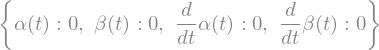

In [43]:
static_repl = {alpha.diff(): 0, beta.diff(): 0, alpha: 0, beta: 0}
static_repl

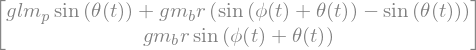

In [44]:
f_static = f.subs(static_repl)
f_static

In [45]:
sm.solve(f_static, theta, phi)

Let's look at the simulation with the initial condition very close to an equilibrium point:

In [46]:
sys.coordinates['theta'] = np.deg2rad(180.0000001)
sys.coordinates['phi'] = -np.deg2rad(180.00000001)

In [47]:
traj = sys.free_response(20, sample_rate=500)

In [48]:
sys.animate_configuration(fps=30, repeat=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
traj[['theta', 'phi']].plot(subplots=True);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

This equlibrium point is an *unstable equlibrium*.

# Linearizing the system

The equations of motion can be linearized about one of the equilibrium points. This can be done by computing the linear terms of the multivariate Taylor Series expansion. This expansion can be expressed as:

$$
\mathbf{f}_{linear} = \mathbf{f}(\mathbf{v}_{eq}) + \mathbf{J}_{f,v}(\mathbf{v}_{eq}) (\mathbf{v} - \mathbf{v}_{eq})
$$

where $\mathbf{J}_f$ is the Jacobian of $\mathbf{f}$ with respect to $\mathbf{v}$ and:

$$
\mathbf{v} = \begin{bmatrix}
\theta\\
\phi \\
\alpha \\
\beta \\
\dot{\alpha} \\
\dot{\beta}
\end{bmatrix}
$$

In our case let's linearize about the static position where $\theta=\phi=0$.

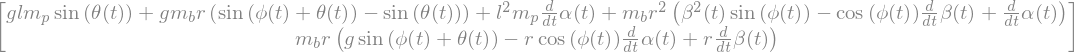

In [50]:
f

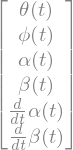

In [51]:
v = sm.Matrix([theta, phi, alpha, beta, alpha.diff(), beta.diff()])
v

In [52]:
veq = sm.zeros(len(v), 1)
veq

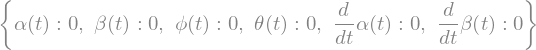

In [53]:
v_eq_sub = dict(zip(v, veq))
v_eq_sub

The linear equations are then:

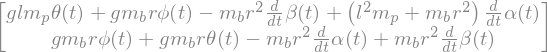

In [54]:
f_lin = f.subs(v_eq_sub) + f.jacobian(v).subs(v_eq_sub) * (v - veq)
f_lin

Note that all of the terms that involve the coordinates, speeds, and their derivatives are linear terms, i.e. simple linear coefficients. These linear equations can be put into this canonical form:

$$\mathbf{M}\dot{\mathbf{s}} + \mathbf{C}\mathbf{s} + \mathbf{K} \mathbf{c} = \mathbf{F}$$

with:

- $\mathbf{M}$ as the mass matrix
- $\mathbf{C}$ as the damping matrix
- $\mathbf{K}$ as the stiffness matrix
- $\mathbf{F}$ as the forcing vector

The Jacobian can again be utlized to extract the linear coefficients.

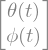

In [55]:
cbar = sm.Matrix([theta, phi])
cbar

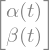

In [56]:
sbar

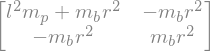

In [57]:
M = f_lin.jacobian(sbar.diff())
M

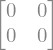

In [58]:
C = f_lin.jacobian(sbar)
C

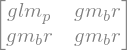

In [59]:
K = f_lin.jacobian(cbar)
K

In [60]:
F = -f_lin.subs(v_eq_sub)
F

# Simulate the linear system

In [61]:
from resonance.linear_systems import BallChannelPendulumSystem

In [62]:
lin_sys = BallChannelPendulumSystem()

For linear systems, a function that calculates the canonical coefficient matrices should be created. Each of the canonical matrices should be created as 2 x 2 NumPy arrays.

In [63]:
def canon_coeff_matrices(mp, mb, l, g, r):
    M = np.array([[mp * l**2 + mb * r**2, -mb * r**2],
                  [-mb * r**2, mb * r**2]])
    C = np.zeros((2, 2))
    K = np.array([[g * l * mp, g * mb * r],
                  [g * mb * r, g * mb * r]])
    return M, C, K

In [64]:
lin_sys.canonical_coeffs_func = canon_coeff_matrices

In [65]:
M_num, C_num, K_num = lin_sys.canonical_coefficients()

In [66]:
M_num

array([[ 5.15e-04, -3.50e-05],
       [-3.50e-05,  3.50e-05]])

In [67]:
C_num

array([[0., 0.],
       [0., 0.]])

In [68]:
K_num

array([[0.023544 , 0.0034335],
       [0.0034335, 0.0034335]])

In [69]:
lin_traj = lin_sys.free_response(20, sample_rate=500)

In [70]:
lin_traj[['theta', 'phi']].plot(subplots=True);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Compare the nonlinear and linear simulations

In [71]:
sys.coordinates['theta'] = np.deg2rad(10)
sys.coordinates['phi'] = np.deg2rad(-10)

In [72]:
lin_sys.coordinates['theta'] = np.deg2rad(10)
lin_sys.coordinates['phi'] = np.deg2rad(-10)

In [73]:
traj = sys.free_response(10.0)

In [74]:
lin_traj = lin_sys.free_response(10.0)

In [75]:
axes = traj[['theta', 'phi']].plot(subplots=True, color='red')
axes = lin_traj[['theta', 'phi']].plot(subplots=True, color='blue', ax=axes)
axes[0].legend([r'nonlin $\theta$', r'lin $\theta$'])
axes[1].legend([r'nonlin $\phi$', r'lin $\phi$']);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …